In [386]:
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import numdifftools as nd
from scipy.stats import skew, kurtosis, boxcox
from scipy.special import inv_boxcox

In [387]:
df = pd.read_csv('./../data/price_elasticity_data.csv')

In [388]:
df.isnull().sum()

Product              0
Menu_Price           0
Pizza_Count          0
Profit_Percentage    0
dtype: int64

rename columns

In [389]:
names = {'Menu_Price': 'unit_price', 'Pizza_Count': 'quantity', 'Profit_Percentage': 'profit_percentage'}
df.rename(columns=names, inplace=True)

# calculate additional features

In [390]:
df['gross_margin'] = df['profit_percentage'] / 100
df['gross_profit'] = df['unit_price'] * (1 - df['gross_margin'])
df['cost'] = df['unit_price'] - df['gross_profit']

# Subset the dataframe for 'Individuale' product and create a copy

In [391]:
individuale_df = df[df['Product'] == 'Individuale'].copy()

In [392]:
individuale_df.isnull().sum()

Product              0
unit_price           0
quantity             0
profit_percentage    0
gross_margin         0
gross_profit         0
cost                 0
dtype: int64

In [393]:
individuale_df['unit_price'].max()

np.float64(18.61)

In [394]:
def identify_outliers(df, column):
    """
     Identify outliers in a specified column of a DataFrame using the 
     Interquartile Range (IQR) method.
     
     The function calculates the first quartile (Q1) and the third quartile 
     (Q3) of the specified column. The interquartile range (IQR) is then 
     computed as the difference between Q3 and Q1.
    
     Outliers are defined as data points that fall below Q1 - 1.5 * IQR or 
     above Q3 + 1.5 * IQR. The function returns the rows containing these  
     outliers along with the calculated lower and upper bounds.

    :param df: 
    :param column: 
    :return: tuple: A tuple containing:
        - pandas.DataFrame: A DataFrame containing the rows identified as outliers.
        - float: The lower bound for identifying outliers.
        - float: The upper bound for identifying outliers.
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)], lower_bound, upper_bound

In [395]:
individuale_outliers, indiv_lower, indiv_upper = identify_outliers(individuale_df, 'unit_price')

remove outliers

In [396]:
individuale_df = individuale_df.drop(individuale_outliers[individuale_outliers['unit_price'] > indiv_upper].index)
individuale_df = individuale_df.drop(individuale_outliers[individuale_outliers['unit_price'] < indiv_lower].index)

# Apply Box-Cox transformation
based on analysis of 13 alternatives in the `EDA_v2` notebook

In [397]:
def apply_boxcox_and_calculate_stats(df, features):
    stats = {}
    lambdas = {}
    for feature in features:
        df[f'BoxCox_{feature}'], fitted_lambda = boxcox(df[feature] + 1)
        lambdas[feature] = fitted_lambda
        skewness = skew(df[f'BoxCox_{feature}'])
        kurt = kurtosis(df[f'BoxCox_{feature}'])
        stats[feature] = (skewness, kurt)
        print(f"Feature: {feature}")
        print(f"Box-Cox Transformed: Skewness = {skewness:.4f}, Kurtosis = {kurt:.4f}\n")
    return df, stats, lambdas

In [398]:
features = ['unit_price', 'quantity', 'gross_profit', 'cost']

In [399]:
individuale_df, individuale_stats, fitted_lambdas = apply_boxcox_and_calculate_stats(individuale_df, features)

Feature: unit_price
Box-Cox Transformed: Skewness = -0.0073, Kurtosis = -0.0553

Feature: quantity
Box-Cox Transformed: Skewness = -0.0858, Kurtosis = 1.7082

Feature: gross_profit
Box-Cox Transformed: Skewness = 0.0032, Kurtosis = 0.4552

Feature: cost
Box-Cox Transformed: Skewness = -0.0345, Kurtosis = -0.2547



In [400]:
# Calculate mean cost from the original data
mean_cost = np.mean(individuale_df['cost'])

# Fit linear regression model

In [401]:
# Fit linear regression model
x_value = individuale_df['BoxCox_unit_price']
y_value = individuale_df['BoxCox_quantity']
assert len(x_value) == len(y_value), "x and y must have the same length"
X = add_constant(x_value)
model = sm.OLS(y_value, X)
individuale_result = model.fit()
print(individuale_result.summary())

                            OLS Regression Results                            
Dep. Variable:        BoxCox_quantity   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     300.0
Date:                Sun, 04 Aug 2024   Prob (F-statistic):           1.94e-26
Time:                        20:32:14   Log-Likelihood:                 1722.9
No. Observations:                  69   AIC:                            -3442.
Df Residuals:                      67   BIC:                            -3437.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0816   2.18e-1

# Analysis

# Get prediction values

In [402]:
predictions = individuale_result.predict(X)
predictions_original = inv_boxcox(predictions, fitted_lambdas['quantity'])
individuale_df['predicted_quantities'] = predictions_original

# Create a scatter plot with the regression line based on the original data

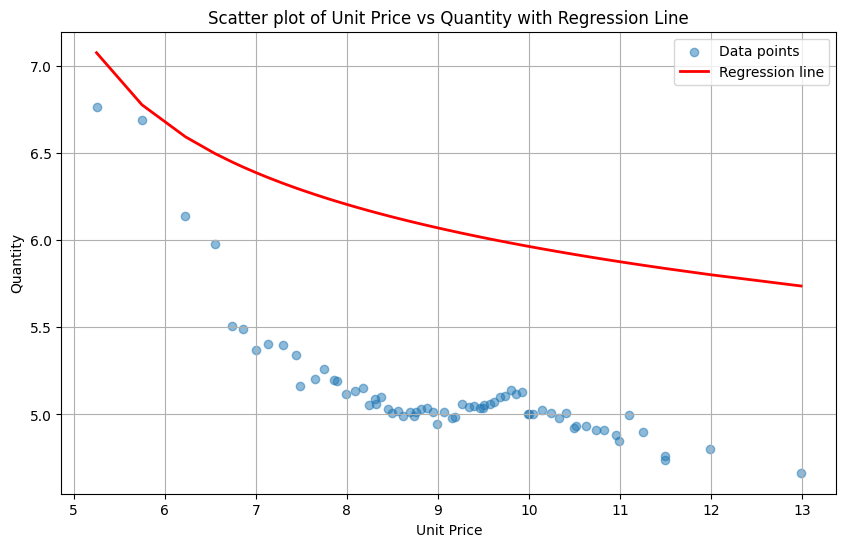

In [403]:
plt.figure(figsize=(10, 6))
plt.scatter(individuale_df['unit_price'], individuale_df['quantity'], alpha=0.5, label='Data points')
plt.plot(individuale_df['unit_price'], predictions_original, color='red', linewidth=2, label='Regression line')
plt.title('Scatter plot of Unit Price vs Quantity with Regression Line')
plt.xlabel('Unit Price')
plt.ylabel('Quantity')
plt.legend()
plt.grid(True)
plt.show()

# Analysis
The regression line represents the relationship between unit rice and quantity demanded as modelled by simple linear regression. We can use it to derive our Price elasticity of demand (PED)

The regression line can be expressed as:
$$\text{Quantity} = \alpha + \beta \times \text{Price}$$

where:
- $\alpha$ is the intercept of the line.
- $\beta$ is the slope of the regression line

From our regression summary we know that:
- $\alpha = 0.0816$
- $\beta = -2.68e-12$

In [404]:
# Calculate the gross profit based on the inverse transformed predictions
individuale_df['gross_profit_predictions'] = (individuale_df['unit_price'] - individuale_df['cost']) * individuale_df['predicted_quantities']

# Access alpha and beta directly from the fitted model

In [405]:
alpha = individuale_result.params['const']
alpha

np.float64(0.08155912112753438)

In [406]:
beta = individuale_result.params['BoxCox_unit_price']
beta

np.float64(-2.679773255506895e-12)

# Calculate mean price and mean quantity

In [407]:
individuale_mean_price = np.mean(individuale_df['unit_price'])
individuale_mean_quantity = np.mean(individuale_df['quantity'])

# Calculate PED

Price elasticity of demand. In general terms we can express this algebraically as:

$$\text{PED} = \dfrac{\Delta{Q}/Q}{\Delta{P}/P}$$

Where:
- $\Delta{Q}$ is the change in quantity demanded.
- $Q$ is the initial quantity demanded.
- $\Delta{P}$ is the change in price.
- $P$ is the initial price.

In [408]:
ped = beta * (individuale_mean_price / individuale_mean_quantity)
print(f'Price Elasticity of Demand: {ped}')

Price Elasticity of Demand: -4.745236119704167e-12


individuale is more elastic than Communita

# Find the price that maximizes gross profit

In [409]:
optimal_price = individuale_df.loc[individuale_df['gross_profit_predictions'].idxmax(), 'unit_price']
max_gross_profit = individuale_df['gross_profit_predictions'].max()
optimal_quantity = individuale_df.loc[individuale_df['gross_profit_predictions'].idxmax(), 'predicted_quantities']

In [410]:
# Define the gross profit function based on the regression model in the original space
def gross_profit_function(price):
    boxcox_price = (price + 1) ** fitted_lambdas['unit_price'] - 1
    return (price - mean_cost) * (individuale_result.params['const'] + individuale_result.params['BoxCox_unit_price'] * boxcox_price)

Calculate the first derivative (slope) at the optimal price

In [411]:
derivative_function = nd.Derivative(gross_profit_function)
slope_at_optimal_price = derivative_function(optimal_price)

first derivative given point and slope

In [412]:
# fix_me
x1, y1 = optimal_price, max_gross_profit
slope = slope_at_optimal_price
intercept = y1 - slope * x1
x_vals = np.linspace(individuale_df['unit_price'].min(), individuale_df['unit_price'].max(), 100)
y_vals = slope * x_vals + intercept

# Plot the transformed gross profit curve

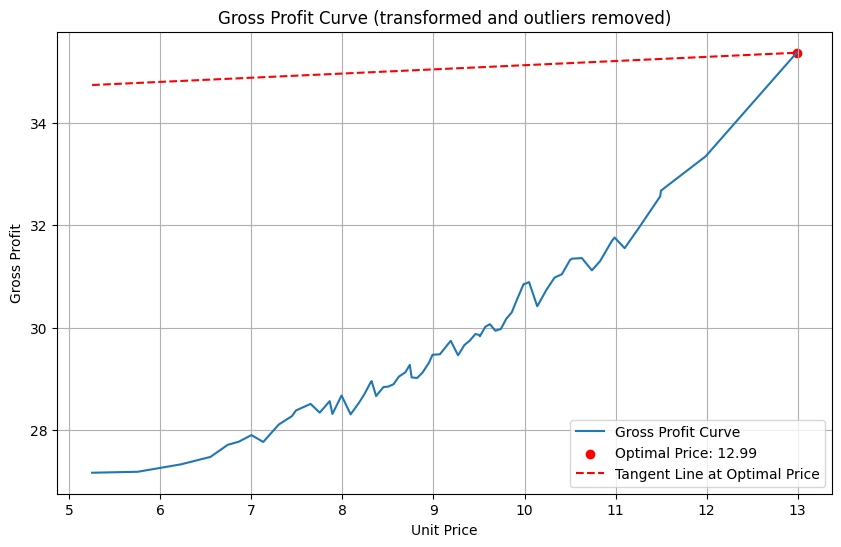

In [413]:
plt.figure(figsize=(10, 6))
plt.plot(individuale_df['unit_price'], individuale_df['gross_profit_predictions'], label='Gross Profit Curve')
plt.scatter(optimal_price, max_gross_profit, color='red', label=f'Optimal Price: {optimal_price:.2f}')
plt.plot(x_vals, y_vals, color='red', linestyle='--', label=f'Tangent Line at Optimal Price')
plt.title('Gross Profit Curve (transformed and outliers removed)')
plt.xlabel('Unit Price')
plt.ylabel('Gross Profit')
plt.legend()
plt.grid(True)
plt.show()

Print the optimal price and slope at that point

In [414]:
print(f'Optimal Price (Original): {round(optimal_price, 2)}')
print(f'Optimal Quantity (Original): {round(optimal_quantity, 0)}')
print(f'Maximum Gross Profit: {round(max_gross_profit, 2)}')
print(f'Slope of the Gross Profit Function at Optimal Price: {slope_at_optimal_price}')

Optimal Price (Original): 12.99
Optimal Quantity (Original): 6.0
Maximum Gross Profit: 35.37
Slope of the Gross Profit Function at Optimal Price: 0.08155912099718347


# Analysis

# Extend the predictions
Create a new range of unit prices extending beyond the observed data

In [415]:
new_unit_prices = np.linspace(individuale_df['unit_price'].min(), 40, 100)
new_X = sm.add_constant(new_unit_prices)
new_predictions = individuale_result.predict(new_X)

Calculate the gross profit for the new unit prices. Assuming cost remains constant, using the mean cost from the original data

In [416]:
new_gross_profits = (new_unit_prices - mean_cost) * new_predictions

Find the price that maximizes gross profit

In [417]:
max_index = np.argmax(new_gross_profits)
optimal_price_extended = new_unit_prices[np.argmax(new_gross_profits)]
max_gross_profit_extended = new_gross_profits.max()
optimal_quantity_extended = new_predictions[max_index]

In [418]:
def extended_gross_profit_function(price):
    boxcox_price = (price + 1) ** fitted_lambdas['unit_price'] - 1
    return (price - mean_cost) * (individuale_result.params['const'] + individuale_result.params['BoxCox_unit_price'] * boxcox_price)

Calculate the slope of the first derivative at the optimal price

In [419]:
slope_at_optimal_price_extended = nd.Derivative(extended_gross_profit_function)(optimal_price_extended)


# Plot the extended gross profit curve

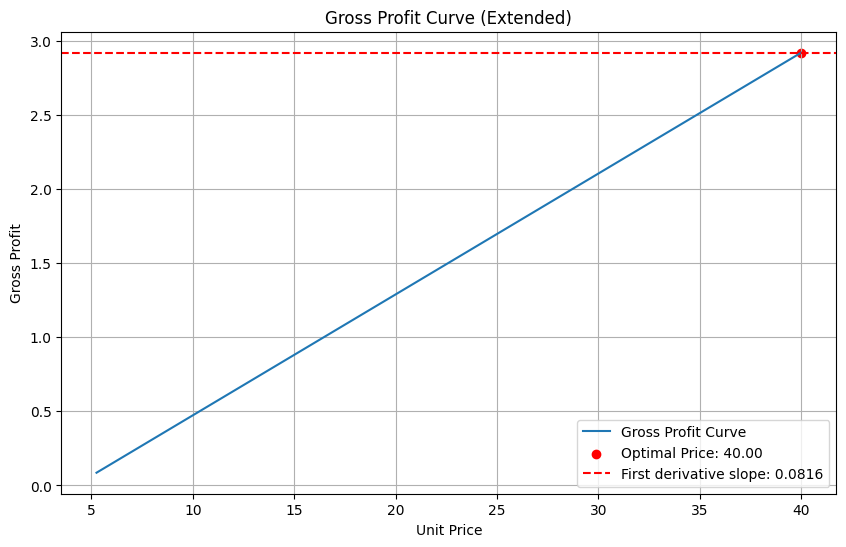

In [420]:
plt.figure(figsize=(10, 6))
plt.plot(new_unit_prices, new_gross_profits, label='Gross Profit Curve')
plt.scatter(optimal_price_extended, max_gross_profit_extended, color='red', label=f'Optimal Price: {optimal_price_extended:.2f}')
plt.axhline(y=max_gross_profit_extended, color='red', linestyle='--', label=f'First derivative slope: {slope_at_optimal_price_extended:.4f}')
plt.title('Gross Profit Curve (Extended)')
plt.xlabel('Unit Price')
plt.ylabel('Gross Profit')
plt.legend()
plt.grid(True)
plt.show()

# Print the optimal price and maximum gross profit

In [421]:
print(f'Optimal Price: {round(optimal_price_extended, 2)}')
print(f'Optimal Quantity (Extended): {round(optimal_quantity_extended, 0)}')
print(f'Maximum Gross Profit: {round(max_gross_profit_extended, 2)}')
print(f'Slope of the Gross Profit Function at Optimal Price (Extended): {slope_at_optimal_price_extended}')

Optimal Price: 40.0
Optimal Quantity (Extended): 0.0
Maximum Gross Profit: 2.92
Slope of the Gross Profit Function at Optimal Price (Extended): 0.0815591205263941


# Analysis
So, on the face of it, the optimal price point is 22.23 which is confirmed by the slope of the first derivative, which is very close to 0. 

However, because we're making predictions outside the dataset, it can only be considered a hypothesis at this point. We have no data to substantiate it. We should set up an experiment to gather more data about sales quantities at higher price points.

- Hypothesis ($H_1$): The optimal unit price that maximises gross profit is 22.23.
- Null Hypothesis ($H_0$): The optimal unit price that maximises gross profit is different from 22.23.